## Lab 7.01 TensorFlow Keras pandas DataFrame classification 
Adapted from the TensorFlow tutorials by Jeff Hale

This lab uses a small [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) provided by the Cleveland Clinic Foundation for Heart Disease. There are several hundred rows in the CSV. Each row describes a patient, and each column describes a feature. We will use this information to predict whether a patient has heart disease (the target column).

We suggest running this lab in [Google Colab](https://colab.research.google.com/). 

Go *File*->*Upload notebook* to upload this notebook to colab.

If you are working in Colab and want to see if you can get a speed boost, set your runtime to *TPU* by going to *Runtime*->*Change runtime type* in the menu above. 

The processor type won't make a big difference with this small dataset and small networks, but it's good to know how to change the processor.

## Read data using pandas

#### Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Retrieve the csv file containing the heart dataset that ships with TensorFlow.

In [2]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/applied-dl/heart.csv')

Load the csv file using pandas.

In [3]:
df = pd.read_csv(csv_file)

In [4]:
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


Check the value counts

In [6]:
df['thal'].value_counts()

normal        168
reversible    115
fixed          18
2               1
1               1
Name: thal, dtype: int64

# Load data
 You could load data using `tf.data.Dataset`, but these are unwieldly - it's a serious pain to create a validation dataset from a TF dataset.. Your best bet is to make your data into a numpy array when needed.

In [7]:
y = df['target']
X = df.drop(columns=['target'])
X.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal


In [8]:
y.head(2)

0    0
1    1
Name: target, dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)

Convert `thal` column to numeric

### Let's use a friendlier OHE! 🎉

In [10]:
!pip install category_encoders 
import category_encoders as ce

ERROR: Could not install packages due to an EnvironmentError: [Errno 2] No such file or directory: '/Users/kelly/anaconda3/envs/dsir/lib/python3.7/site-packages/numpy-1.19.2.dist-info/METADATA'



In [11]:
ohe = ce.OneHotEncoder()
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)
X_train

/Users/kelly/anaconda3/envs/dsir/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal_1,thal_2,thal_3,thal_4,thal_5
7,57,0,4,120,354,0,0,163,1,0.6,1,0,1,0,0,0,0
2,67,1,4,120,229,0,2,129,1,2.6,2,2,0,1,0,0,0
55,52,1,2,120,325,0,0,172,0,0.2,1,0,1,0,0,0,0
56,44,1,3,140,235,0,2,180,0,0.0,1,0,1,0,0,0,0
82,51,1,4,140,261,0,2,186,1,0.0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,48,1,4,130,256,1,2,150,1,0.0,1,2,0,1,0,0,0
59,51,0,3,130,256,0,2,149,0,0.5,1,0,1,0,0,0,0
221,64,1,1,170,227,0,2,155,0,0.6,2,0,0,1,0,0,0
41,65,0,3,155,269,0,0,148,0,0.8,1,0,1,0,0,0,0


#### Set the random seed

In [12]:
tf.random.set_seed(123)

## Create and train a model

#### Create model structure

In [13]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(17,)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 17)                68        
_________________________________________________________________
dense (Dense)                (None, 20)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 649
Trainable params: 615
Non-trainable params: 34
_________________________________________________________________


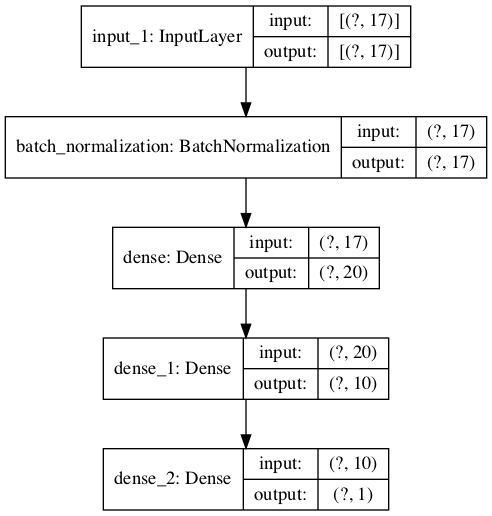

In [15]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
)

#### Compile

In [16]:
 model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', 'Recall', 'Precision'],
    )

#### Make an EarlyStopping callback

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#### Fit the model

In [18]:
history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_split=0.2, callbacks=[callback])  
history

Train on 181 samples, validate on 46 samples
Epoch 1/50
181/181 [==============================] - 1s 7ms/sample - loss: 0.8059 - accuracy: 0.3370 - Recall: 0.3333 - Precision: 0.1538 - val_loss: 0.8118 - val_accuracy: 0.6957 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00
Epoch 2/50
181/181 [==============================] - 0s 232us/sample - loss: 0.7461 - accuracy: 0.4088 - Recall: 0.2083 - Precision: 0.1266 - val_loss: 0.7014 - val_accuracy: 0.6957 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00
Epoch 3/50
181/181 [==============================] - 0s 168us/sample - loss: 0.6936 - accuracy: 0.5746 - Recall: 0.1667 - Precision: 0.1778 - val_loss: 0.6527 - val_accuracy: 0.6957 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00
Epoch 4/50
181/181 [==============================] - 0s 188us/sample - loss: 0.6572 - accuracy: 0.6519 - Recall: 0.1250 - Precision: 0.2222 - val_loss: 0.6294 - val_accuracy: 0.6957 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00
Epoch 5/50
18

#### Plot model performance on the training data

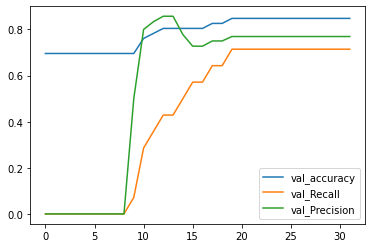

In [19]:
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_Recall'], label='val_Recall')
plt.plot(history.history['val_Precision'], label='val_Precision')
plt.legend();

#### Save model

In [20]:
model.save('heart_1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: heart_1/assets


In [21]:
!ls

7.01-lab-nn-classification-solution.ipynb
heart_1
model.png


#### Load model

In [22]:
reloaded_model = tf.keras.models.load_model('heart_1')

In [23]:
reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  68        
_________________________________________________________________
dense (Dense)                multiple                  360       
_________________________________________________________________
dense_1 (Dense)              multiple                  210       
_________________________________________________________________
dense_2 (Dense)              multiple                  11        
Total params: 649
Trainable params: 615
Non-trainable params: 34
_________________________________________________________________


#### Evaluate on test set 

In [24]:
reloaded_model.evaluate(X_test, y_test)

76/76 [==============================] - 0s 5ms/sample - loss: 0.3479 - accuracy: 0.8421 - Recall: 0.7619 - Precision: 0.6957


[0.34785928381116765, 0.84210527, 0.7619048, 0.6956522]

In [25]:
model.evaluate(X_test, y_test) 

76/76 [==============================] - 0s 63us/sample - loss: 0.3479 - accuracy: 0.8421 - Recall: 0.7619 - Precision: 0.6957


[0.34785928381116765, 0.84210527, 0.7619048, 0.6956522]

**X_test predictions**

In [26]:
preds = model.predict(X_test)
preds

array([[0.01498905],
       [0.01932371],
       [0.5773739 ],
       [0.00174993],
       [0.02302352],
       [0.8277743 ],
       [0.0348275 ],
       [0.20786172],
       [0.08289191],
       [0.02255499],
       [0.71953046],
       [0.00109449],
       [0.5950312 ],
       [0.01461941],
       [0.02161494],
       [0.00171506],
       [0.09273902],
       [0.0141376 ],
       [0.06542042],
       [0.34346253],
       [0.23443022],
       [0.5643003 ],
       [0.01964921],
       [0.7575983 ],
       [0.06917933],
       [0.02905887],
       [0.614987  ],
       [0.00208586],
       [0.51606935],
       [0.5851793 ],
       [0.23726055],
       [0.0713205 ],
       [0.07359684],
       [0.07179752],
       [0.7436948 ],
       [0.7459712 ],
       [0.01137313],
       [0.45831865],
       [0.79311436],
       [0.1775499 ],
       [0.1587829 ],
       [0.78527236],
       [0.79116374],
       [0.05859289],
       [0.00552154],
       [0.06935269],
       [0.24209258],
       [0.882

#### What do those look like?

In [27]:
preds.round()

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.]], dtype=float

#### How is the model performing? 
Let's look at the confusion matrix.

In [28]:
tf.math.confusion_matrix(labels=y_test, predictions=preds.round())

<tf.Tensor: id=8274, shape=(2, 2), dtype=int32, numpy=
array([[48,  7],
       [ 5, 16]], dtype=int32)>

Or just use sklearn's confusion matrix. 

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
confusion_matrix(y_test, preds.round())

array([[48,  7],
       [ 5, 16]])

In [31]:
tn, fp, fn, tp = confusion_matrix(y_test, preds.round()).ravel()
tn

48

#### Evaluate with other metrics

In [32]:
from sklearn.metrics import recall_score, precision_score, f1_score, balanced_accuracy_score

In [33]:
recall_score(y_test, preds.round())

0.7619047619047619

In [34]:
f1_score(y_test, preds.round())

0.7272727272727272

In [35]:
balanced_accuracy_score(y_test, preds.round())

0.8173160173160172

### Make a null model

In [36]:
y_test.value_counts(normalize=True)

0    0.723684
1    0.276316
Name: target, dtype: float64

## Can you make a better model?

Change the model architecture and see if you can make a better model. Add nodes, dense layers, and dropout layers.

#### Save your best model. 


#### Compare your best neural net model to a  scikit-learn Logistic Regression model. Also try a GradientBoostingClassifier.

In [37]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#### Scale and Standardize for Logistic Regression


In [38]:
ss = StandardScaler()

In [39]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

#### Logistic Regression

In [40]:
log_reg = LogisticRegressionCV(Cs=[.1, 1, 10, 100], random_state=123)
log_reg.fit(X_train_sc, y_train)
log_reg.score(X_test_sc, y_test)

0.8421052631578947

In [41]:
log_reg.C_ # best value for C

array([10.])

In [42]:
lr_preds = log_reg.predict(X_test_sc)

Evaluate performance on metrics other than accuracy

In [43]:
f1_score(y_test, lr_preds)

0.7

In [44]:
precision_score(y_test, lr_preds)

0.7368421052631579

In [45]:
balanced_accuracy_score(y_test, lr_preds)

0.7878787878787878

### GradientBoosting

In [46]:
pg = dict(
    max_depth=[2, 3], 
    n_estimators=[100, 1000]
    )
gs = GridSearchCV(GradientBoostingClassifier(random_state=123), param_grid=pg, n_jobs=-1)
gs.fit(X_train, y_train)
gs.score(X_test, y_test)

0.8157894736842105

In [47]:
boost_preds = gs.predict(X_test)
boost_preds

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [48]:
gs.best_params_

{'max_depth': 2, 'n_estimators': 100}

Evaluate on metrics other than accuracy.

In [49]:
recall_score(y_test, boost_preds)

0.5238095238095238

In [50]:
precision_score(y_test, boost_preds)

0.7333333333333333

In [51]:
f1_score(y_test, boost_preds )

0.611111111111111

In [52]:
balanced_accuracy_score(y_test, boost_preds)

0.7255411255411255

#### Which evaluation metric(s) are best to use in this problem?

I would argue the F1 score is the best metric in this case. It encompasses both the precision and the recall. The model's ability to discriminate true positives from false positives and false negatives is important for heart disease detection. 




#### Which model would you recommend a medical service provider use?

The neural net model performed slightly better than the LogisticRegression model and a good bit better than the GradientBoostingClassifier on the test set. Althought the dataset was small and I would like more data, with the data available, if prediction is most important, I would choose to use the neural net model.


#### Download your notebook and put it in your submission folder. 🎉